In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB7

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
# Load and preprocess the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/FracAtlas/images/',
    label_mode='binary',
    seed=123,
    validation_split=0.1,
    subset="both",
    image_size=(600, 600),
    batch_size=16,
)

Found 3996 files belonging to 2 classes.
Using 3597 files for training.
Using 399 files for validation.


In [3]:
inputs = layers.Input(shape=(600, 600, 3))
model = EfficientNetB7(include_top=False, input_tensor=inputs, weights='imagenet')
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", 'AUC', 'Precision', 'Recall']
)

model.load_weights('../method-3/fracatlas/efficientnetb7_weights.h5')

25/25 [==============================] - 28s 736ms/step
              precision    recall  f1-score   support

         0.0       0.61      0.60      0.60        72
         1.0       0.91      0.91      0.91       327

    accuracy                           0.86       399
   macro avg       0.76      0.76      0.76       399
weighted avg       0.86      0.86      0.86       399

Confusion Matrix:


<Axes: >

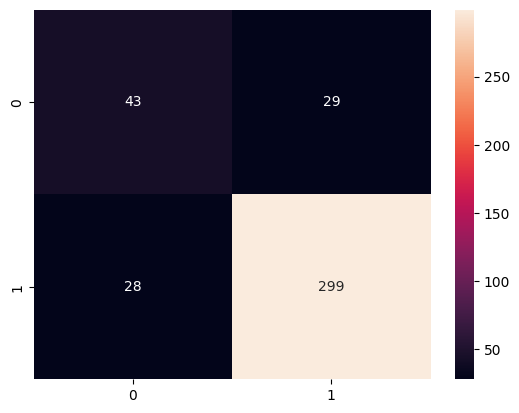

In [4]:
# Get the predictions on the validation data
y_pred = model.predict(dataset[1])

# Convert the predictions to binary values
y_pred_binary = (y_pred > 0.5).astype(int)

# Get the true labels from the validation data
y_true = np.concatenate([y for x, y in dataset[1]], axis=0)

# Generate the classification report
report = classification_report(y_true, y_pred_binary)
print(report)

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_true,y_pred_binary),annot = True,fmt='d')